In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [5]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
print(df_train.info())
df_train.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
568,569,0,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S
417,418,1,2,"Silven, Miss. Lyyli Karoliina",female,18.0,0,2,250652,13.0000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
160,161,0,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.1000,NaN,S
393,394,1,1,"Newell, Miss. Marjorie",female,23.0,1,0,35273,113.2750,D36,C


In [8]:
print(df_test.info())
df_test.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
130,1022,3,"Spinner, Mr. Henry John",male,32.00,0,0,STON/OQ. 369943,8.0500,NaN,S
58,950,3,"Davison, Mr. Thomas Henry",male,NaN,1,0,386525,16.1000,NaN,S
354,1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.17,1,2,C.A. 2315,20.5750,NaN,S
161,1053,3,"Touma, Master. Georges Youssef",male,7.00,1,1,2650,15.2458,NaN,C
276,1168,2,"Parker, Mr. Clifford Richard",male,28.00,0,0,SC 14888,10.5000,NaN,S
206,1098,3,"McGowan, Miss. Katherine",female,35.00,0,0,9232,7.7500,NaN,Q
93,985,3,"Guest, Mr. Robert",male,NaN,0,0,376563,8.0500,NaN,S
46,938,1,"Chevre, Mr. Paul Romaine",male,45.00,0,0,PC 17594,29.7000,A9,C
144,1036,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",male,42.00,0,0,17475,26.5500,NaN,S
89,981,2,"Wells, Master. Ralph Lester",male,2.00,1,1,29103,23.0000,NaN,S


In [9]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [12]:
df_all.dropna(subset = ["Embarked"], inplace=True)
df_train.dropna(subset = ["Embarked"], inplace=True)
df_test.dropna(subset = ["Embarked"], inplace=True)

In [14]:
df_all.dropna(subset = ["Fare"], inplace=True)
df_train.dropna(subset = ["Fare"], inplace=True)
df_test.dropna(subset = ["Fare"], inplace=True)

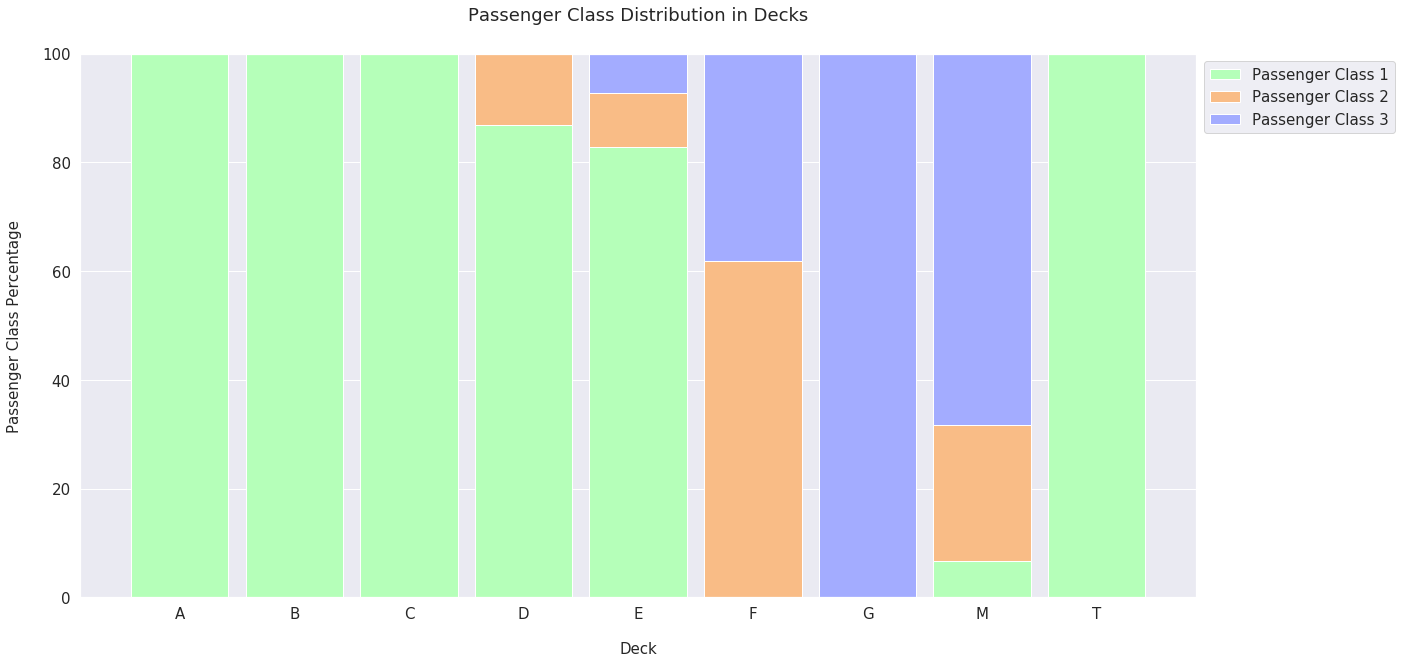

In [17]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [18]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

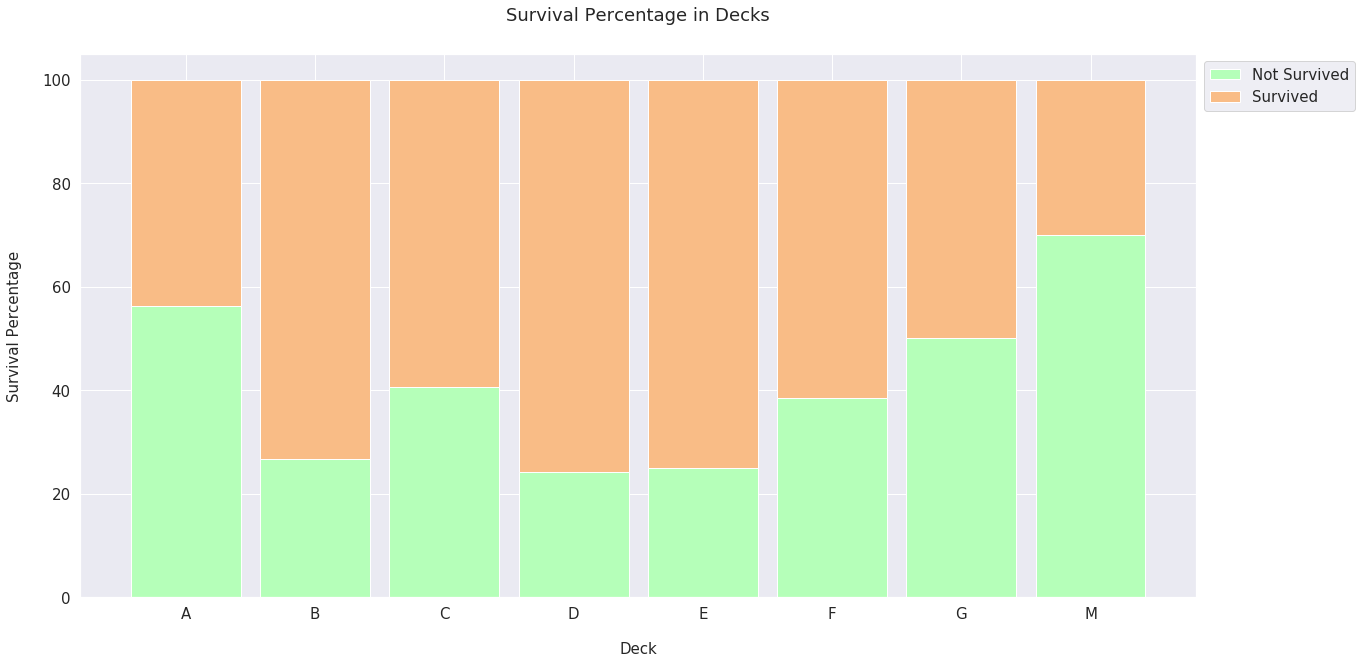

In [19]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)


In [20]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1013
ABC     180
DE       87
FG       26
Name: Deck, dtype: int64